# Pitfalls - Fxp Arithmetic

We have confirmed the precision issues or input limitations with the following ops.

We will update this part promptly.

## Simulation

We will use SPU **simulation** tool to simulate multi-parties with threads.



In [1]:
import spu
import jax.numpy as jnp
import numpy as np
from matplotlib import pyplot as plt

# import spu simulation module
import spu.utils.simulation as pps


## Default Runtime Config Parameters

We will use the following common settings in SPU Runtime config. Other parameters may be modified however.

In [2]:
DEFAULT_SPU_PROTOCOL = spu.ProtocolKind.ABY3
DEFAULT_SPU_FIELD = spu.FieldType.FM64
DEFAULT_SPU_FXP_FRACTION_BITS = 18


## Unary Operator

### Reciprocal

SPU uses Goldschmidt's method to calculate Reciprocal. Please refer to [Secure Computation With Fixed-Point Numbers](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.221.1305&rep=rep1&type=pdf) for details.

Reciprocal is only correct if input belongs to **(-2\*\*fxp_fraction_bits, 2\*\*fxp_fraction_bits)**.

First, let's have a look at the figure.

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


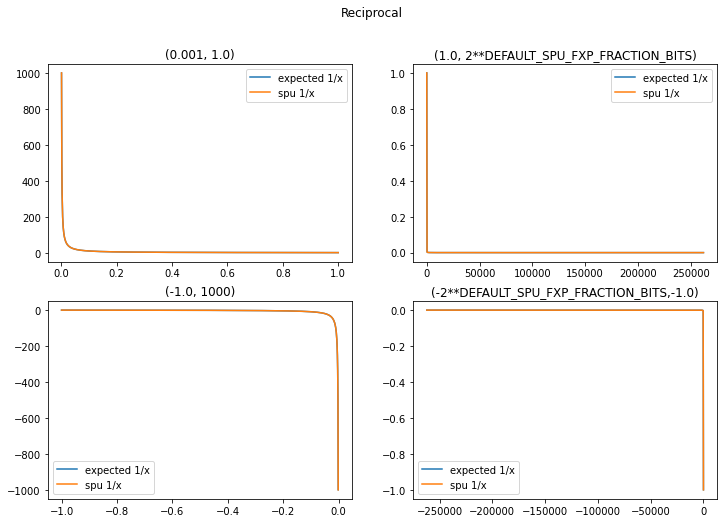

In [3]:
config = spu.RuntimeConfig(
    protocol=DEFAULT_SPU_PROTOCOL,
    field=DEFAULT_SPU_FIELD,
    fxp_fraction_bits=DEFAULT_SPU_FXP_FRACTION_BITS,
)
simulator = pps.Simulator(3, config)
spu_reciprocal = pps.sim_jax(simulator, jnp.reciprocal)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("Reciprocal")


def plot_reciprocal(spu_reciprocal, ax, x, title):
    (line1,) = ax.plot(x, 1.0 / x, label='expected 1/x')
    (line2,) = ax.plot(x, spu_reciprocal(x), label='spu 1/x')
    ax.legend()
    ax.title.set_text(title)


plot_reciprocal(spu_reciprocal, ax1, np.linspace(0.001, 1.0, num=1000), '(0.001, 1.0)')
plot_reciprocal(
    spu_reciprocal,
    ax2,
    np.linspace(1.0, 2**DEFAULT_SPU_FXP_FRACTION_BITS - 1, num=1000),
    '(1.0, 2**DEFAULT_SPU_FXP_FRACTION_BITS)',
)
plot_reciprocal(
    spu_reciprocal, ax3, np.linspace(-1.0, -0.001, num=1000), '(-1.0, 1000)'
)
plot_reciprocal(
    spu_reciprocal,
    ax4,
    np.linspace(-(2**DEFAULT_SPU_FXP_FRACTION_BITS) + 1, -1.0, num=1000),
    '(-2**DEFAULT_SPU_FXP_FRACTION_BITS,-1.0)',
)
plt.show()


Actually the precision is quite high.

In [4]:
x = np.linspace(
    -(2**DEFAULT_SPU_FXP_FRACTION_BITS) + 1,
    2**DEFAULT_SPU_FXP_FRACTION_BITS - 1,
    num=1000,
)
expected_y = 1.0 / x
y = spu_reciprocal(x)

assert np.allclose(y, expected_y, rtol=1e-04, atol=1e-5)


Let's have an idea about what happens if input is not within the valid range.

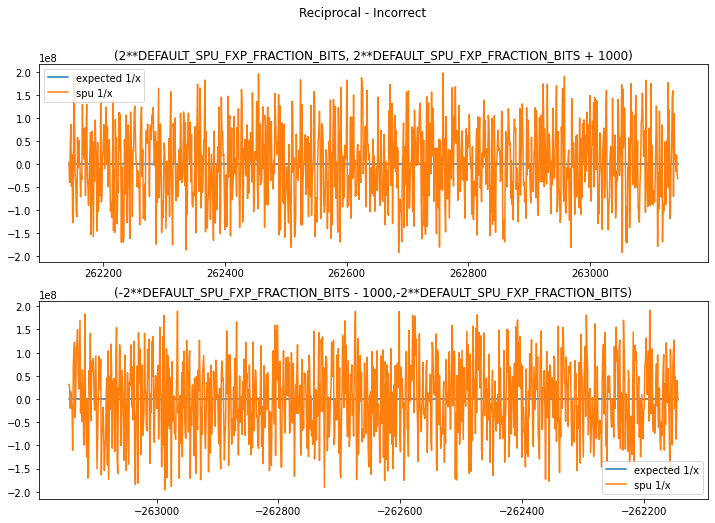

In [5]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(12, 8))
fig.suptitle("Reciprocal - Incorrect")


def plot_reciprocal(spu_reciprocal, ax, x, title):
    (line1,) = ax.plot(x, 1.0 / x, label='expected 1/x')
    (line2,) = ax.plot(x, spu_reciprocal(x), label='spu 1/x')
    ax.legend()
    ax.title.set_text(title)


plot_reciprocal(
    spu_reciprocal,
    ax1,
    np.linspace(2**DEFAULT_SPU_FXP_FRACTION_BITS, 2**DEFAULT_SPU_FXP_FRACTION_BITS + 1000, num=1000),
    '(2**DEFAULT_SPU_FXP_FRACTION_BITS, 2**DEFAULT_SPU_FXP_FRACTION_BITS + 1000)',
)

plot_reciprocal(
    spu_reciprocal,
    ax2,
    np.linspace(-(2**DEFAULT_SPU_FXP_FRACTION_BITS) - 1000, -2**DEFAULT_SPU_FXP_FRACTION_BITS, num=1000),
    '(-2**DEFAULT_SPU_FXP_FRACTION_BITS - 1000,-2**DEFAULT_SPU_FXP_FRACTION_BITS)',
)
plt.show()


### Natural Logarithm

SPU uses Pade approximation by default. Please check [Benchmarking Privacy Preserving Scientific Operations](https://www.esat.kuleuven.be/cosic/publications/article-3013.pdf) for details.

Logarithm is only correct if input belongs to **(0, 2\*\*fxp_fraction_bits)**.

> **_NOTE:_**  Similar conclusion also applies to **log1p**, **log2**.

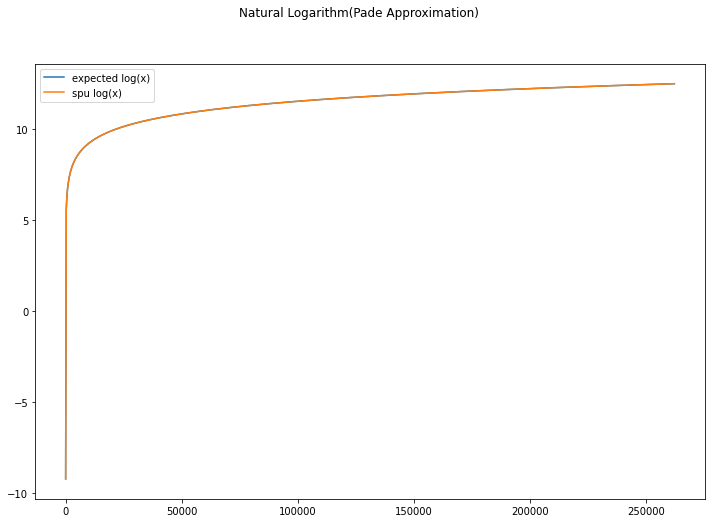

In [6]:
config = spu.RuntimeConfig(
    protocol=DEFAULT_SPU_PROTOCOL,
    field=DEFAULT_SPU_FIELD,
    fxp_fraction_bits=DEFAULT_SPU_FXP_FRACTION_BITS,
)
simulator = pps.Simulator(3, config)

spu_log = pps.sim_jax(simulator, jnp.log)
x = np.linspace(0.0001, 2**DEFAULT_SPU_FXP_FRACTION_BITS - 1, num=1000)
expected_y = np.log(x)
y = spu_log(x)

fig, ax = plt.subplots(figsize=(12, 8))
fig.suptitle("Natural Logarithm(Pade Approximation)")
(line1,) = ax.plot(x, expected_y, label='expected log(x)')
(line2,) = ax.plot(x, y, label='spu log(x)')
ax.legend()
plt.show()


In [7]:
assert np.allclose(y, expected_y, rtol=1e-3, atol=1e-5)


Again, let's see what happens if input is out of valid range.

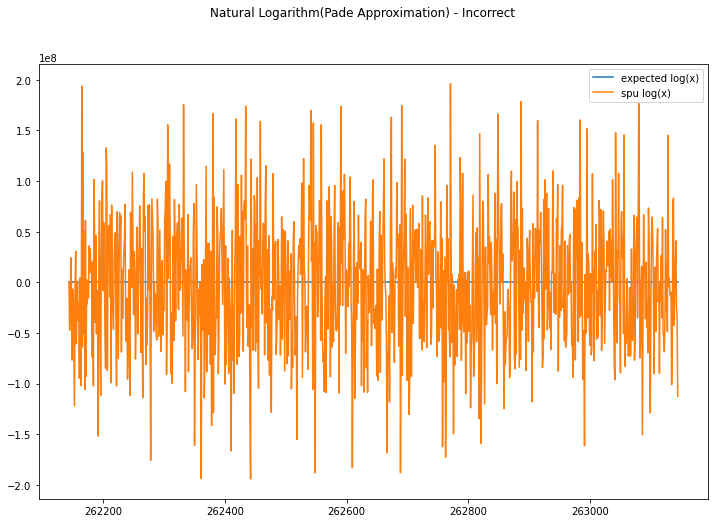

In [8]:
x = np.linspace(2**DEFAULT_SPU_FXP_FRACTION_BITS,2**DEFAULT_SPU_FXP_FRACTION_BITS + 1000 , num=1000)
expected_y = np.log(x)
y = spu_log(x)

fig, ax = plt.subplots(figsize=(12, 8))
fig.suptitle("Natural Logarithm(Pade Approximation) - Incorrect")
(line1,) = ax.plot(x, expected_y, label='expected log(x)')
(line2,) = ax.plot(x, y, label='spu log(x)')
ax.legend()
plt.show()

#### Another Choice: Newton Approximation

If you would like to compute faster, you may switch to Newton Approximation.
But the precision is lower and valid input range is around **(0, 250)**.

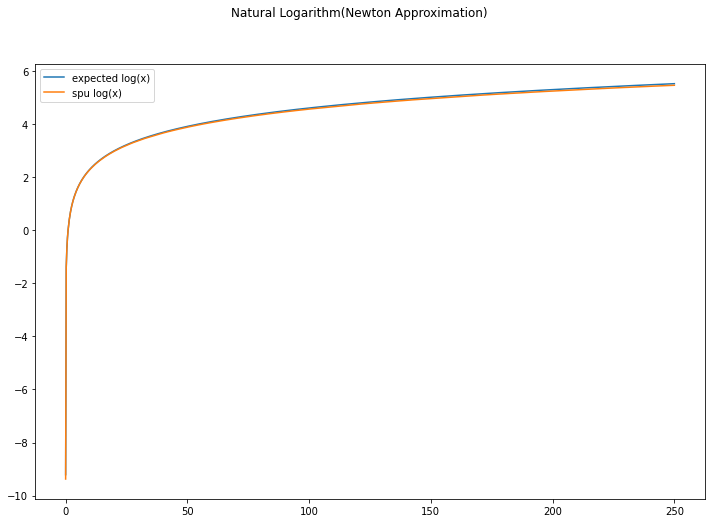

In [9]:
config = spu.RuntimeConfig(
    protocol=DEFAULT_SPU_PROTOCOL,
    field=DEFAULT_SPU_FIELD,
    fxp_fraction_bits=DEFAULT_SPU_FXP_FRACTION_BITS,
    fxp_log_mode=spu.RuntimeConfig.LOG_NEWTON,
)
simulator = pps.Simulator(3, config)

spu_log = pps.sim_jax(simulator, jnp.log)
x = np.linspace(0.0001, 250, num=1000)
expected_y = np.log(x)
y = spu_log(x)

fig, ax = plt.subplots(figsize=(12, 8))
fig.suptitle("Natural Logarithm(Newton Approximation)")
(line1,) = ax.plot(x, expected_y, label='expected log(x)')
(line2,) = ax.plot(x, y, label='spu log(x)')
ax.legend()
plt.show()


While, if out of valid input...

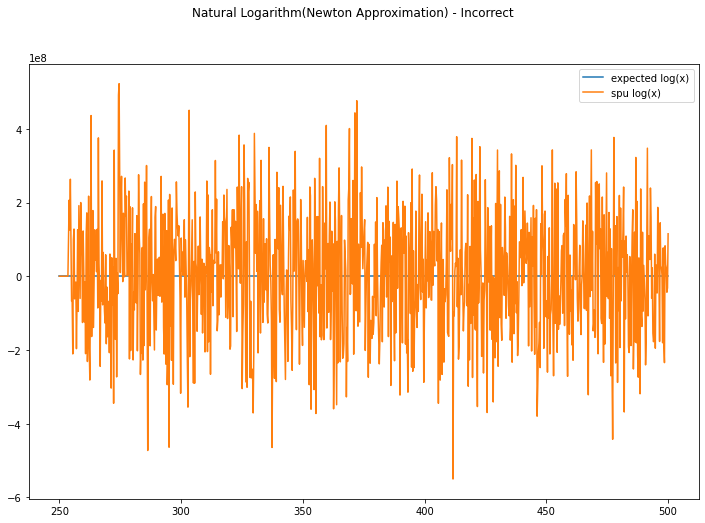

In [10]:
x = np.linspace(250, 500, num=1000)
expected_y = np.log(x)
y = spu_log(x)

fig, ax = plt.subplots(figsize=(12, 8))
fig.suptitle("Natural Logarithm(Newton Approximation) - Incorrect")
(line1,) = ax.plot(x, expected_y, label='expected log(x)')
(line2,) = ax.plot(x, y, label='spu log(x)')
ax.legend()
plt.show()

### Natural Exponential

The current implementation is based on Taylor approximation. The valid input range is around **(0, 10)**.

> **_NOTE:_**  Similar conclusion also applies to **exp2**.



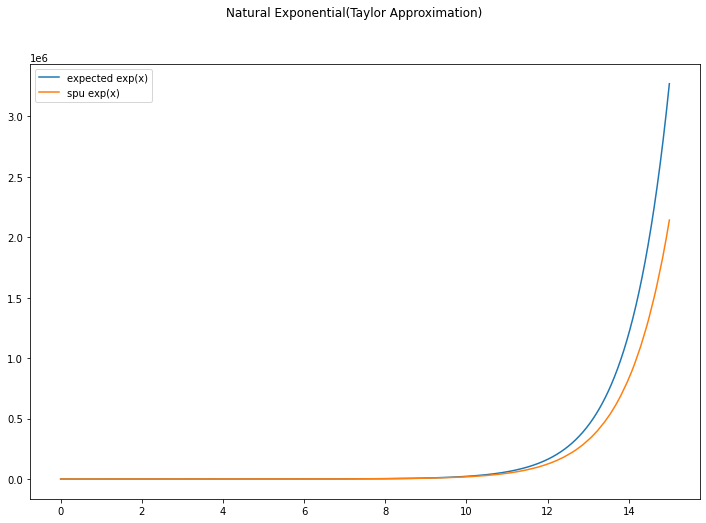

In [11]:
config = spu.RuntimeConfig(
    protocol=DEFAULT_SPU_PROTOCOL,
    field=DEFAULT_SPU_FIELD,
    fxp_fraction_bits=DEFAULT_SPU_FXP_FRACTION_BITS,
)
simulator = pps.Simulator(3, config)

spu_exp = pps.sim_jax(simulator, jnp.exp)
x = np.linspace(0.0001, 15, num=1000)
expected_y = np.exp(x)
y = spu_exp(x)

fig, ax = plt.subplots(figsize=(12, 8))
fig.suptitle("Natural Exponential(Taylor Approximation)")
(line1,) = ax.plot(x, expected_y, label='expected exp(x)')
(line2,) = ax.plot(x, y, label='spu exp(x)')
ax.legend()
plt.show()


If input not in valid range, then...

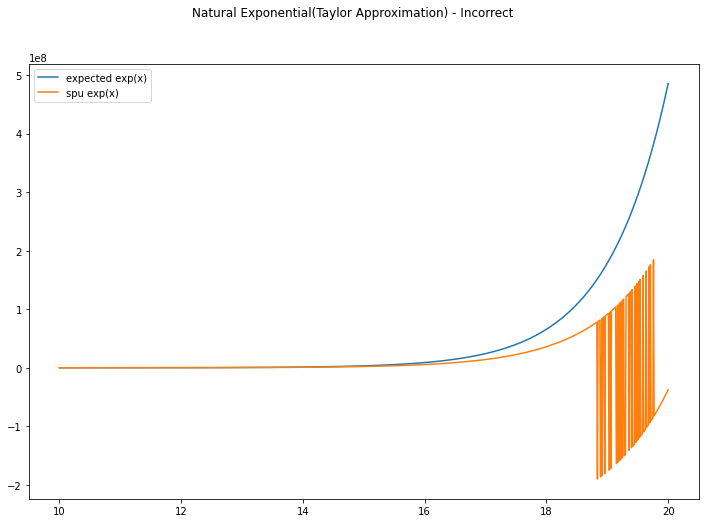

In [12]:
x = np.linspace(10, 20, num=1000)
expected_y = np.exp(x)
y = spu_exp(x)

fig, ax = plt.subplots(figsize=(12, 8))
fig.suptitle("Natural Exponential(Taylor Approximation) - Incorrect")
(line1,) = ax.plot(x, expected_y, label='expected exp(x)')
(line2,) = ax.plot(x, y, label='spu exp(x)')
ax.legend()
plt.show()

#### Another Choice: Pade Approximation

SPU also implements Pade Approximation which has a larger valid input range - **(0, 20)** but with slower computation speed.

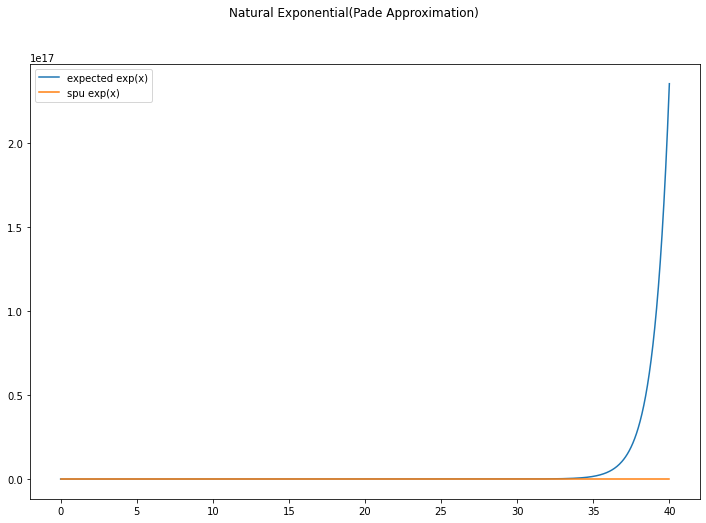

In [13]:
config = spu.RuntimeConfig(
    protocol=DEFAULT_SPU_PROTOCOL,
    field=DEFAULT_SPU_FIELD,
    fxp_fraction_bits=DEFAULT_SPU_FXP_FRACTION_BITS,
    fxp_exp_mode=spu.RuntimeConfig.EXP_PADE,
)
simulator = pps.Simulator(3, config)

spu_exp = pps.sim_jax(simulator, jnp.exp)
x = np.linspace(0.0001, 40, num=1000)
expected_y = np.exp(x)
y = spu_exp(x)

fig, ax = plt.subplots(figsize=(12, 8))
fig.suptitle("Natural Exponential(Pade Approximation)")
(line1,) = ax.plot(x, expected_y, label='expected exp(x)')
(line2,) = ax.plot(x, y, label='spu exp(x)')
ax.legend()
plt.show()


Let's check if input is larger than 20:

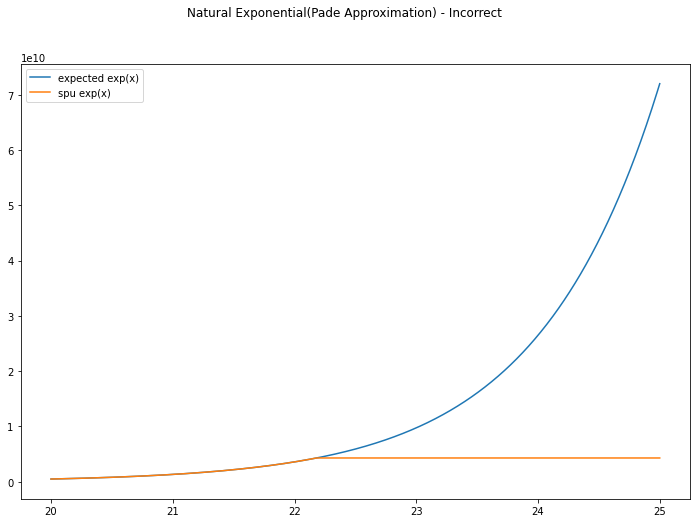

In [14]:
x = np.linspace(20, 25, num=1000)
expected_y = np.exp(x)
y = spu_exp(x)

fig, ax = plt.subplots(figsize=(12, 8))
fig.suptitle("Natural Exponential(Pade Approximation) - Incorrect")
(line1,) = ax.plot(x, expected_y, label='expected exp(x)')
(line2,) = ax.plot(x, y, label='spu exp(x)')
ax.legend()
plt.show()

### Hyperbolic Tangent

SPU uses Pade Approximation for implementation. The parameters refer to [Wolfram](https://www.wolframalpha.com/input?i=Pade+approximation+tanh%28x%29+order+5%2C5).
The valid input range is about **(-5,5)**.



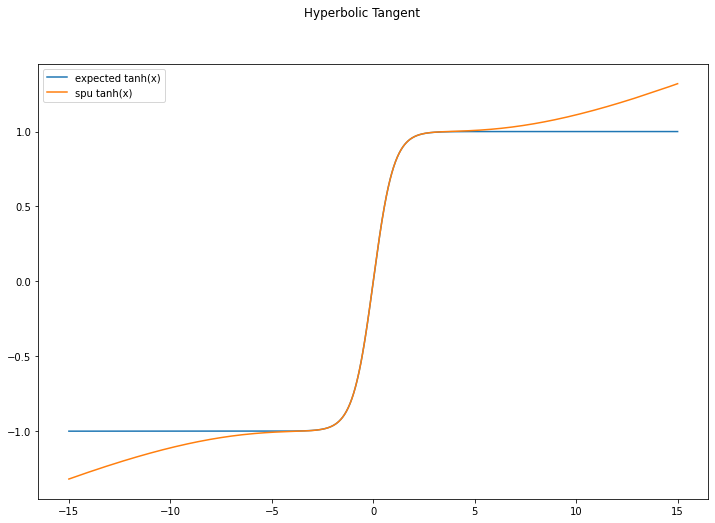

In [15]:
config = spu.RuntimeConfig(
    protocol=DEFAULT_SPU_PROTOCOL,
    field=DEFAULT_SPU_FIELD,
    fxp_fraction_bits=DEFAULT_SPU_FXP_FRACTION_BITS,
)
simulator = pps.Simulator(3, config)

spu_tanh = pps.sim_jax(simulator, jnp.tanh)
x = np.linspace(-15, 15, num=1000)
expected_y = np.tanh(x)
y = spu_tanh(x)

fig, ax = plt.subplots(figsize=(12, 8))
fig.suptitle("Hyperbolic Tangent")
(line1,) = ax.plot(x, expected_y, label='expected tanh(x)')
(line2,) = ax.plot(x, y, label='spu tanh(x)')
ax.legend()
plt.show()

## Binary Operator

### Div

SPU uses Goldschmidt's method to calculate division. Please refer to [Secure Computation With Fixed-Point Numbers](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.221.1305&rep=rep1&type=pdf) for details.

To calculate **div(a, b)**, i.e. **a / b**, SPU transits it to **a * reciprocal(b)**, so we have a similar valid input range to **b**, which is **(-2\*\*fxp_fraction_bits, 2\*\*fxp_fraction_bits)**. Please check details at **reciprocal** part.